# Music genre classification

This project aims at creation Convolutional neural network for music classifiction. Data used for the project is taken from https://github.com/mdeff/fma 

## DATA
All metadata and features for all tracks are distributed in fma_metadata.zip (342 MiB). The below tables can be used with pandas or any other data analysis tool. S

tracks.csv: per track metadata such as ID, title, artist, genres, tags and play counts, for all 106,574 tracks.

genres.csv: all 163 genre IDs with their name and parent (used to infer the genre hierarchy and top-level genres).

features.csv: common features extracted with librosa.

echonest.csv: audio features provided by Echonest (now Spotify) for a subset of 13,129 tracks.

Then, you got various sizes of MP3-encoded audio data:

fma_small.zip: 8,000 tracks of 30s, 8 balanced genres (GTZAN-like) (7.2 GiB) 

fma_medium.zip: 25,000 tracks of 30s, 16 unbalanced genres (22 GiB) 

fma_large.zip: 106,574 tracks of 30s, 161 unbalanced genres (93 GiB) 

fma_full.zip: 106,574 untrimmed tracks, 161 unbalanced genres (879 GiB) 

Due to limited time and computing capabilities fma_small.zip archive was used.


# Install Deps


In [3]:
%tensorflow_version 2.x
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dense, Dropout 
from IPython.display import Image, display 
import datetime

from google.colab import drive

print(tf.version)

#enable detailed output for troubleshooting and additional deatails on setup.
tf.get_logger().setLevel('INFO')

TensorFlow 2.x selected.
<module 'tensorflow_core._api.v2.version' from '/tensorflow-2.1.0/python3.6/tensorflow_core/_api/v2/version/__init__.py'>


In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## First step of the project was to process the MP3 files to spectograms. 
Spectogram is representaion of audio file as a picture where on the x axis is presented time, on y axis is presented frequency and audio amplitude is color coded. 
For prosessing of the audio file I used librosa library
https://librosa.github.io/librosa/index.html

![alt text](https://librosa.github.io/librosa/_images/librosa-decompose-decompose-1.png)

With small function that is called for each file it was easy to construct the pictures (not part of this jypiter notebook)

def Spect(f):
    #F is file name
    #Load the audio as a waveform `y`
    #Store the sampling rate as `sr`
    x, sr = sf.read(f, dtype='float32')
    #performe fast Fourier transform
    stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
    mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    log_mel = librosa.amplitude_to_db(mel)
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    pylab.savefig('Spectogram\\'+ f[4:][:8] +'.png', bbox_inches=None, pad_inches=0)
    print('Spectogram\\'+ f[4:][:8] +'.png')
    
    
Function trimmed the picture frame and axis information was hidden in order to avoid misleading the neural network on the next step. 
I have tested also few other options for spectrogram generation as librosa is slowing down over time when called for 8000 file and it looks like there is memmory leakeage as it was consuming a lot of memory. However other spectograms were not looking so nice as the one produced by librosa. Music Smaples are 30s long. I have used 10s out of each music file.

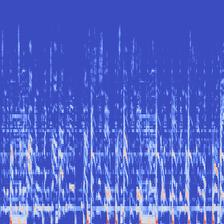

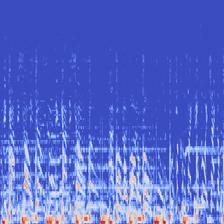

In [5]:
#Spectogram examples used as input for neural network
display(Image('drive/My Drive/MusicDeepL/Spectogram_JPG_dataset/000002.jpg'))
display(Image('drive/My Drive/MusicDeepL/Spectogram_JPG_dataset/000005.jpg'))

# Inspect Data

coming back to Free music acrive (FMA) I used tracks.csv to map the file names to genre. For this I would need file name and genre.

In [0]:
#importing only tracks, set_size and genre. Low_memory = False to skip the waring of type conversion.
data = pd.read_csv('drive/My Drive/MusicDeepL/fma_metadata/tracks.csv', usecols=[0, 32, 40], low_memory=False)

In [7]:
#rename the DF columns
data.rename(columns={'Unnamed: 0': 'track_id', 'set.1': 'set_size', 'track.7': 'Genre' }, inplace=True)
data.head()

,track_id,set_size,Genre
0,NaN,subset,genre_top
1,track_id,NaN,NaN
2,2,small,Hip-Hop
3,3,medium,Hip-Hop
4,5,small,Hip-Hop


In [0]:
#select only data for the "small" dataset
data = data[data.set_size == 'small']

AS there was a problem and tf.dataset complianign the my labels were string instead of float32, I did mapping from string to numer. Function below is doing the convertion. 

In [0]:
def tran_cat_to_num(df):
    if df['Genre'] == 'Electronic':
        return 1
    elif df['Genre'] == 'Experimental':
        return 2
    elif df['Genre'] == 'Folk':
        return 3
    elif df['Genre'] == 'Hip-Hop':
        return 4
    elif df['Genre'] == 'Instrumental':
        return 5
    elif df['Genre'] == 'International':
        return 6
    elif df['Genre'] == 'Pop':
        return 7
    elif df['Genre'] == 'Rock':
        return 8
# create sex_new 
data['Genre_new']=data.apply(tran_cat_to_num,axis=1)

In [10]:
#check if there is NaN values
data.isnull().sum().sum()

0

In [11]:
#check if data was loaded correct and check the content with "head()" 8K samples 
print(data.describe())
print(data.head())

         Genre_new
count  8000.000000
mean      4.500000
std       2.291431
min       1.000000
25%       2.750000
50%       4.500000
75%       6.250000
max       8.000000
   track_id set_size    Genre  Genre_new
2         2    small  Hip-Hop          4
4         5    small  Hip-Hop          4
5        10    small      Pop          7
17      140    small     Folk          3
18      141    small     Folk          3


# Preprocess Data
I have tried 2 options here:
1. I have sort the files in folders base on genre. Problem that occure here is that I had only one dataset. I have tried to split the data later using tf.dataset.take() and tf.dataset.skip() but for some reason the perfronace was no good, it took a lot of time to build shuffle buffer. 


    train_size = int(0.7 * len(filenames))
    val_size = int(0.15 * len(filenames))
    test_size = int(0.15 * len(filenames))
    dataset = dataset.shuffle(buffer_size=(int(len(filenames))), reshuffle_each_iteration=False)
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)
    val_dataset = test_dataset.skip(test_size)
    test_dataset = test_dataset.take(test_size)



2. Option 2 was to use sklearn train_test_spilt and to apply this on the train.csv and files. In this case I had two data sets and I have build 2 tf.dataset as separate ones. This solution was working smooth and I have decide (even that the course trainer stressed not to mix the tensorflow and sklearn) to use this option as the split was done before buidling the datasets.

In [12]:
#zfill is addinf leading zeros in order that files names in formata 000002.jpg match with the track id 2
filenames = ['drive/My Drive/MusicDeepL/Spectogram_JPG_dataset/' + fname.zfill(6)+'.jpg' for fname in data['track_id'].tolist()]
labels = data['Genre_new'].tolist()


train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames,
                                                                            labels,
                                                                            train_size=0.9,
                                                                            random_state=42)

#get the lenght of the lists. I would need them later to estimate the steps.
num_train = len(train_filenames)
num_val = len(val_filenames)
print(num_train, num_val)

7200 800


In [0]:
#set the image size. Original files we resized to 224x224. as I do not have enough processing power. 
#If I do not have time to train the models I will reduce the size
IMAGE_SIZE = 224

#this funstion is called to tf.dataset pipeline creations as explained 
#here: https://www.tensorflow.org/guide/data#consuming_numpy_arrays
def _parse_fn(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
    image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
    return image_resized, label

#Model parameters

In [0]:
BATCH_SIZE = 32
#train tf.dataset from pipelines
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(_parse_fn).shuffle(buffer_size=num_train).batch(BATCH_SIZE)
#valiation tf.dataset from pipelines
val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(_parse_fn).batch(BATCH_SIZE)

In [0]:
learning_rate = 0.001
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [0]:
num_epochs = 30
steps_per_epoch = round(num_train)//BATCH_SIZE
val_steps = 30

# Define Model 1

In [0]:
#crete tensor board logs
log_dir="drive/My Drive/MusicDeepL/logsModel1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Transfer learning speeds up training by enabling us to reuse existing pre-trained image classification models, only retraining the top layer of the network that determines the classes an image can belong to.

![alt text](https://miro.medium.com/max/999/1*5F4b6ggZY7hlvGHxbrhTyA.png)

In [0]:
# Base model with MobileNetV2
#detailes about MobileNetv2 https://arxiv.org/abs/1801.04381


base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

In [45]:

model1 = tf.keras.Sequential([
    base_model,
    MaxPool2D(),
     
    #Normalize the activations of the previous layer at each batch, i.e. applies a transformation that 
    #maintains the mean activation close to 0 and the activation standard deviation close to 1.
    BatchNormalization(),
    #Flattens the input. Does not affect the batch size.
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(8, activation='sigmoid')
])


model1.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 3, 1280)        5120      
_________________________________________________________________
flatten_4 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1474688   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

### Train model 1

In [46]:
history = model1.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps,
                    callbacks=[tensorboard_callback])

Train for 225 steps, validate for 30 steps
Epoch 1/30
225/225 [==============================] - 35s 158ms/step - loss: 74.8733 - accuracy: 0.3483 - val_loss: 75.1547 - val_accuracy: 0.7083
Epoch 2/30
225/225 [==============================] - 29s 127ms/step - loss: 74.7600 - accuracy: 0.5314 - val_loss: 75.1545 - val_accuracy: 0.0469
Epoch 3/30
225/225 [==============================] - 30s 133ms/step - loss: 74.7581 - accuracy: 0.5090 - val_loss: 75.1545 - val_accuracy: 0.6719
Epoch 4/30
225/225 [==============================] - 29s 129ms/step - loss: 74.7562 - accuracy: 0.7215 - val_loss: 75.1545 - val_accuracy: 0.3146
Epoch 5/30
225/225 [==============================] - 30s 135ms/step - loss: 74.7564 - accuracy: 0.7725 - val_loss: 75.1545 - val_accuracy: 0.4187
Epoch 6/30
225/225 [==============================] - 29s 129ms/step - loss: 74.7562 - accuracy: 0.7811 - val_loss: 75.1545 - val_accuracy: 0.3542
Epoch 7/30
225/225 [==============================] - 29s 129ms/step - loss

In [0]:
# Save model weights
model1.save_weights('drive/My Drive/MusicDeepL/weights_model_1.h5')

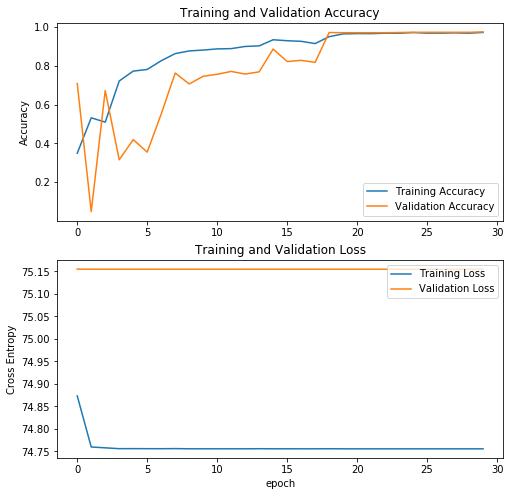

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

accurancy is very low. As next step we could try different trainable layers and simplify the trainable part. Thus we could test the perfomance of MobileNetV2 itself. Or to train the whole MobileNetV2 from scratch. 

# Model 2
Model 2 is using the same pretrained model MobileNetV2 but only changing the output layer. It could be used as a refernce how the ready model is working.

In [0]:
# Base model with MobileNetV2
#detailes about MobileNetv2 https://arxiv.org/abs/1801.04381
#IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

#base_model2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                               include_top=False, 
#                                               weights='imagenet')
#base_model2.trainable = False

In [0]:
#crete tensor board logs
log_dir="drive/My Drive/MusicDeepL/logsModel2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [24]:
model2 = tf.keras.Sequential([
    base_model,
    MaxPool2D(),
    Flatten(),
    Dense(8, activation='sigmoid')
])


model2.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 92168     
Total params: 2,350,152
Trainable params: 92,168
Non-trainable params: 2,257,984
_________________________________________________________________


### Train model 2

In [25]:
history2 = model2.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps,
                    callbacks=[tensorboard_callback])

Train for 225 steps, validate for 30 steps
Epoch 1/30
225/225 [==============================] - 38s 170ms/step - loss: 75.0516 - accuracy: 0.9887 - val_loss: 75.1545 - val_accuracy: 1.0000
Epoch 2/30
225/225 [==============================] - 32s 142ms/step - loss: 74.7559 - accuracy: 1.0000 - val_loss: 75.1545 - val_accuracy: 1.0000
Epoch 3/30
225/225 [==============================] - 33s 146ms/step - loss: 74.7559 - accuracy: 1.0000 - val_loss: 75.1545 - val_accuracy: 1.0000
Epoch 4/30
225/225 [==============================] - 33s 149ms/step - loss: 74.7559 - accuracy: 1.0000 - val_loss: 75.1545 - val_accuracy: 1.0000
Epoch 5/30
225/225 [==============================] - 31s 138ms/step - loss: 74.7559 - accuracy: 1.0000 - val_loss: 75.1545 - val_accuracy: 1.0000
Epoch 6/30
225/225 [==============================] - 32s 143ms/step - loss: 74.7559 - accuracy: 1.0000 - val_loss: 75.1545 - val_accuracy: 1.0000
Epoch 7/30
225/225 [==============================] - 31s 139ms/step - loss

In [0]:
# Save model weights
model2.save_weights('drive/My Drive/MusicDeepL/weights_model_2.h5')

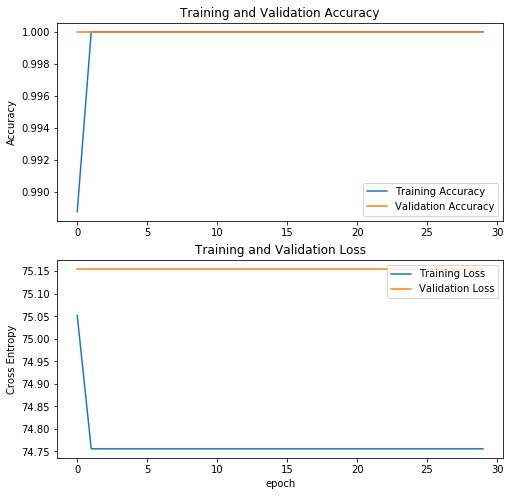

In [29]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Traing Accuracy is good but validation accuracy is lower than 50%. Input data might be bad or sample to be low numbers. I will change the number of epochs and learning rate. 

# Model 3
This model was build from scratch. In general it has more trainable parameters than the other models. 


In [0]:
#This is the same function as used earlier with only differnece that normalization is from 0 to 1. 
def _parse_fn_255(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_normalized = (tf.cast(image_decoded, tf.float32)/255)
    image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
    return image_resized, label

In [0]:
#train tf.dataset from pipelines
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(_parse_fn_255).shuffle(buffer_size=num_train).batch(BATCH_SIZE)
#valiation tf.dataset from pipelines
val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(_parse_fn_255).batch(BATCH_SIZE)

In [0]:
#crete tensor board logs
log_dir="drive/My Drive/MusicDeepL/logsModel3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [0]:
conv_model = tf.keras.Sequential([
    Input(shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
    Conv2D(filters=32, kernel_size=3, padding = "same", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=3, padding = "same", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(filters=128, kernel_size=3, padding = "same", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation = "relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation = "relu"),
    Dropout(0.1),
    Dense(8, activation = "sigmoid"),

])

In [34]:
conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)      

In [0]:
conv_model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train model3

In [36]:
history3 = conv_model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps,
                    callbacks=[tensorboard_callback])

Train for 225 steps, validate for 30 steps
Epoch 1/30
225/225 [==============================] - 41s 183ms/step - loss: 74.8939 - accuracy: 0.1596 - val_loss: 75.3193 - val_accuracy: 1.0000
Epoch 2/30
225/225 [==============================] - 36s 159ms/step - loss: 74.7710 - accuracy: 0.1935 - val_loss: 75.3884 - val_accuracy: 0.0292
Epoch 3/30
225/225 [==============================] - 37s 163ms/step - loss: 74.7632 - accuracy: 0.1549 - val_loss: 75.2048 - val_accuracy: 0.1167
Epoch 4/30
225/225 [==============================] - 36s 162ms/step - loss: 74.7604 - accuracy: 0.1606 - val_loss: 75.1692 - val_accuracy: 0.1646
Epoch 5/30
225/225 [==============================] - 35s 157ms/step - loss: 74.7588 - accuracy: 0.1669 - val_loss: 75.1578 - val_accuracy: 0.1052
Epoch 6/30
225/225 [==============================] - 36s 162ms/step - loss: 74.7582 - accuracy: 0.1711 - val_loss: 75.1551 - val_accuracy: 0.1187
Epoch 7/30
225/225 [==============================] - 37s 167ms/step - loss

In [0]:
# Save model weights
conv_model.save_weights('drive/My Drive/MusicDeepL/weights_model_3.h5')

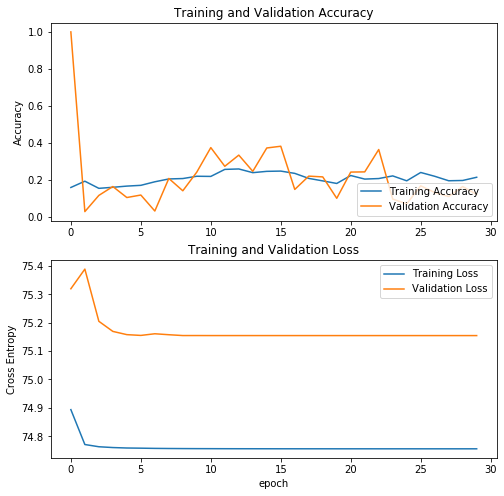

In [38]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tune

Based on the models used the pretrained model2 gave best results. MobileNetV2 was developed to have two classes so as a minimum I have change the classification layer to work with more classes. Model 1 and Model2 were based on MobleNetV2. Model 1 has much more complexity as we have added dense layers but it does not gave the best resutls. 
Model 3 was build from scratch. Obvously it needs optimization. 

1. As a fist step we could change the learning rate for model3.
2. Add more training epochs
3. Used bigger dataset. Two options: split the music files in 10 sec samples (tripple the data size), use bigger data set (we are using FMA small with 8K samples). It would need more time as reported problem with Librosa was slowing the process over time and even crashing due to memory shortage. 
4. Test different Neural network structure
5. Maybe the image was resized quite a lot to 224 pixes and some infomration is missing?! 
6. Unfreeze MobileNetV2 initial layers and train the models from scratch.
7. Use other pretrained model similar to MobileNetV2.

In general good think is that the data input that I have created is not garbage. 
I have decreased the performance of MobileNetV2 by adding layers! 